In [1]:
import numpy as np
import matplotlib.pyplot as plt

from dandi.dandiapi import DandiAPIClient

import h5py
import pynwb
import fsspec
from fsspec.implementations.cached import CachingFileSystem

In [11]:
dandiset_id = '000402'  # ophys dataset from the Tolias Lab
filepath = 'sub-17797/sub-17797_ses-4-scan-7_behavior+image+ophys.nwb'  # 71 GB file
with DandiAPIClient() as client:
    asset = client.get_dandiset(dandiset_id, 'draft').get_asset_by_path(filepath)
    s3_url = asset.get_content_url(follow_redirects=1, strip_query=True)

# first, create a virtual filesystem based on the http protocol
fs = fsspec.filesystem('http')

# create a cache to save downloaded data to disk (optional)
fs = CachingFileSystem(
    fs=fs,
    cache_storage='nwb-cache',  # Local folder for the cache
)

field_idx = 1 #which field to pull images/traces from, integer 1-8
stimulus_trial_type = 'Clip' #stimulus type to randomly draw from (Clip, Trippy, Monet2)


# next, open the file
with fs.open(s3_url, 'rb') as f:
    with h5py.File(f) as file:
        with pynwb.NWBHDF5IO(file=file, load_namespaces=True) as io:
            nwbfile = io.read()
            # retrieve pupil size and position traces and corresponding timestamps (s)
            pupil_timestamps = nwbfile.acquisition['PupilTracking'].time_series['pupil_minor_radius'].timestamps[:]
            pupil_major_radius = nwbfile.acquisition['PupilTracking'].time_series['pupil_minor_radius'].data[:]
            pupil_eye_positions = nwbfile.acquisition['EyeTracking'].spatial_series['eye_position'].data[:]

            # retrieve treadmill velocity trace and corresponding timestamps (s)
            treadmill_velocities = nwbfile.acquisition['treadmill_velocity'].data[:]
            treadmill_times = nwbfile.acquisition['treadmill_velocity'].timestamps[:]

            # retrieve start and end time of random stimulus trial of stimulus_trial_type
            stimulus_trial_idx = np.random.choice(np.arange(len(nwbfile.intervals[stimulus_trial_type].columns[0])),1)
            trial_start_time = nwbfile.intervals[stimulus_trial_type].columns[0][stimulus_trial_idx]
            trial_end_time = nwbfile.intervals[stimulus_trial_type].columns[1][stimulus_trial_idx]

            # retrieve two photon frames between stimulus trial start and end
            twop_acquisition_times = nwbfile.acquisition['TwoPhotonSeries'+str(field_idx)].timestamps[:]
            twop_trial_frames = np.logical_and(twop_acquisition_times >= trial_start_time,
                                               twop_acquisition_times <= trial_end_time)
            twop_acquisition_frames = nwbfile.acquisition['TwoPhotonSeries'+str(field_idx)].data[np.min(np.where(twop_trial_frames)):np.max(np.where(twop_trial_frames))+1,:,:] # T x W x H, where W is AP axis and H is ML axis
            twop_acquisition_frames = np.moveaxis(twop_acquisition_frames,1,2)
            
            # retrieve stimulus movie frames between stimulus trial start and end
            stimulus_times = nwbfile.acquisition['Video: stimulus_17797_4_7_v4'].timestamps[:]
            stimulus_trial_frames = np.logical_and(stimulus_times >= trial_start_time - 2e-4,
                                                   stimulus_times <= trial_end_time + 2e-4)
            stimulus_trial_frames = nwbfile.acquisition['Video: stimulus_17797_4_7_v4'].data[np.min(np.where(stimulus_trial_frames)):np.max(np.where(stimulus_trial_frames))+1,:,:] # T x H x W x 3, all channels equal because grayscale images

            # retrieve fluorescence trace for random neuron
            fluorescence_mask_ids = nwbfile.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries'+str(field_idx)].rois.table.id[:]
            fluorescence_timestamps = nwbfile.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries'+str(field_idx)].timestamps[:]
            fluorescence_mask_idx = np.random.choice(np.arange(len(fluorescence_mask_ids)),1)
            fluorescence_trace = nwbfile.processing['ophys'].data_interfaces['Fluorescence'].roi_response_series['RoiResponseSeries'+str(field_idx)].data[:,fluorescence_mask_idx]

            # retrieve summary images for scan field
            average_image = nwbfile.processing['ophys'].data_interfaces['SegmentationImages'+str(field_idx)].images['average'][:].T
            correlation_image = nwbfile.processing['ophys'].data_interfaces['SegmentationImages'+str(field_idx)].images['correlation'][:].T

            # retrieve segmentation images for scan field
            element_identifiers = nwbfile.processing['ophys'].data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation'+str(field_idx)].id[:]
            element_identifiers = nwbfile.processing['ophys'].data_interfaces['ImageSegmentation'].plane_segmentations['PlaneSegmentation'+str(field_idx)].columns[:]


            

            


            



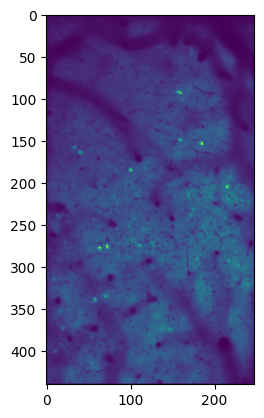

In [91]:
plt.imshow(average_image)

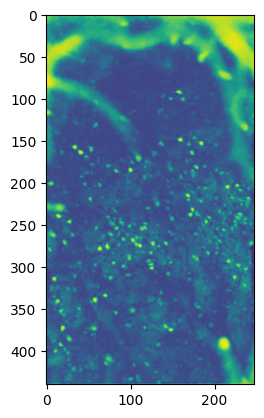

In [92]:
plt.imshow(correlation_image.T)

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [4]:
movie_data = twop_acquisition_frames

In [5]:
# Create a function to update the animation frames
def update_frame(frame):
    plt.clf()  # Clear the previous frame
    plt.imshow(movie_data[frame], cmap='viridis')
    plt.axis('off')

In [ ]:
# Create the animation
fig = plt.figure(figsize=(6, 4))
animation = FuncAnimation(fig, update_frame, frames=movie_data.shape[0], interval=100)

# Display the animation as an embedded movie in the notebook
html_movie = animation.to_jshtml()
display(HTML(html_movie))

In [ ]:

# Create a sample 3D array (replace this with your actual data)
# The array should have dimensions: (frames, height, width)
# For example, you can generate random frames as follows:
frames = 30
height = 200
width = 300
movie_data = np.random.random((frames, height, width))








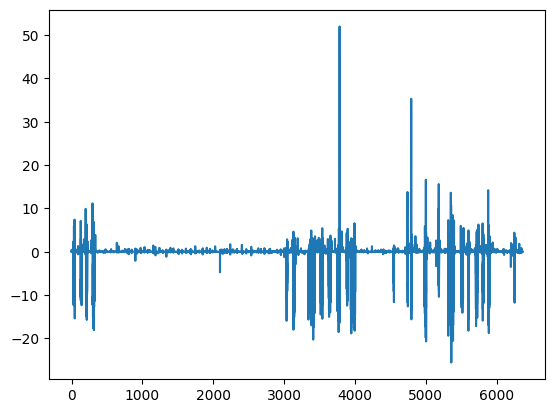

In [ ]:
plt.plot(treadmill_times,treadmill_velocities)

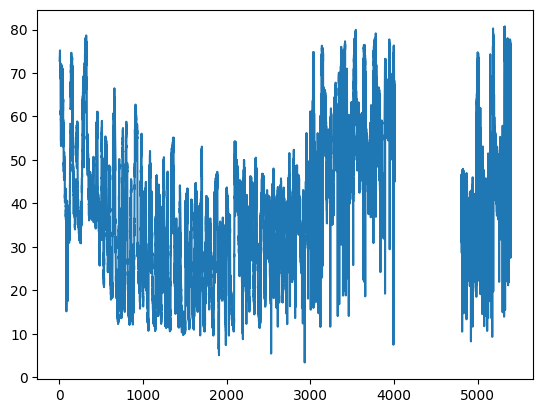

In [11]:
plt.plot(pupil_timestamps,pupil_major_radius)

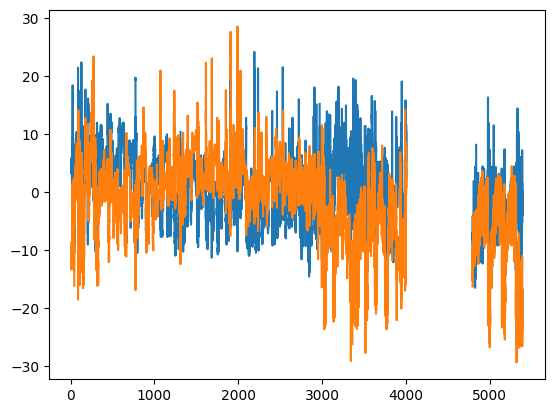

In [12]:
plt.plot(pupil_timestamps,pupil_eye_positions - np.nanmedian(pupil_eye_positions,axis=0,keepdims=True))



In [ ]:
#TODO:
#visualize clip from motion and raster corrected movies for a single trial
#visualize average images and segmentation for a single trial
#visualize fluorescence
#visualize oracle raster
#visualize monet raster

